# LSTM

Apziva project #5<br>
2023 09 04

__Summary:__
* This notebook uses __LSTM (Long Short Term Memory)__ to forecast Microsoft stock market prices.
* The model is __fairly good__ in predicting a __price from the three previous prices__.

## TOC: <a class="anchor" id="TOC"></a>
* [Utilities](#Utilities)
* [Sources](#Sources)
* [Get the data](#GetData)
* [EDA](#EDA)
* [Windowed dataframe](#WindowedDataFrame)
* [Splitting data into train, validation and test sets](#SplittingDataIntoDatasets)
* [Training an LSTM Model](#TrainingLstmModel)
* [Dataset plots: predictions vs. observations](#DatasetPlots)
    * [Training](#PlotWithinTraining)
    * [Validation](#PlotWithinValidation)
    * [Testing](#PlotWithinTesting)
    * [All datasets](#PlotWithinAll)
* [Recursive Predictions for Validation and Testing Data](#RecursivePredictionsForValidationAndTestingData)
* [Add recursive data to plot](#AddRecursiveDataToPlot)
* [Questions](#Questions)

## Utilities <a class="anchor" id="Utilities"></a>
[TOC](#TOC)

In [1]:
# own libraries
import Utilities as u
import MachineLearning as ml

# activate changes in libraries
import importlib
importlib.reload(u)
importlib.reload(ml)

# aliases
from Utilities import TypeChecker as t
from Utilities import PrintAlias as p

## Sources <a class="anchor" id="Sources"></a>
[TOC](#TOC)

* https://github.com/itzsamr/Microsoft-Stock-LSTM-Prediction
* https://github.com/itzsamr/Microsoft-Stock-LSTM-Prediction/blob/main/Stock%20Price%20Prediction/Microsoft%20Stock%20Price%20Prediction%20with%20LSTM%20Neural%20Networks.ipynb

## Get the data <a class="anchor" id="GetData"></a>
[TOC](#TOC)

In [3]:
import pandas as pd
import pickle

In [30]:
def SourceData(strFilename,strDateColumn,strYColumn,strStartDate,strEndDate,blnVerbose=False):
    '''
    Loads time series data
    When       Who What
    2023 09 29 dh  Created
    '''

    # load data from pickle file
    with open(strFilename, 'rb') as objBufferedWriter: # rb = read in binary mode
        dfrSource = pickle.load(objBufferedWriter)
        
    # filter to establish the same situation as tutorial
    datStart = pd.to_datetime(strStartDate).date() 
    datEnd = pd.to_datetime(strEndDate).date()    
    dfrSource = dfrSource[(dfrSource.index >= datStart) & (dfrSource.index <= datEnd)]
    
    # index as "Date" column
    dfrSource.reset_index(inplace=True)
    dfrSource.rename(columns={'index': strDateColumn}, inplace=True)
    dfrSource = dfrSource[[strDateColumn, strYColumn]]
        
    # checks
    if blnVerbose:
        u.ShortDataFrameDisplay(dfrSource)
        u.DisplayDataFrame(dfrSource.describe().T)
        
    # finalize
    return dfrSource

strFilename = f"../data/processed/dfrMain.p"    
strStartDate = '1986-03-13'
strEndDate   = '2023-06-23'
strDateColumn = "Date"
strYColumn = "Close"
df = SourceData(strFilename,strDateColumn,strYColumn,strStartDate, strEndDate,blnVerbose=False)
u.ShortDataFrameDisplay(df)

DataFrame 'df':


,Date,Close
0,1986-03-13,0.060396
1,1986-03-14,0.062553
...,...,...
9394,2023-06-22,338.992279
9395,2023-06-23,334.312164


__Remarks__
* Same record count.
* Same shape.
* Missing weekends as in tutorial.
* Small deviations in price.

In [31]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df.pop('Date')
u.ShortDataFrameDisplay(df)

DataFrame 'df':


,Close
Date,
1986-03-13,0.060396
1986-03-14,0.062553
...,...
2023-06-22,338.992279
2023-06-23,334.312164


## EDA <a class="anchor" id="EDA"></a>
[TOC](#TOC)

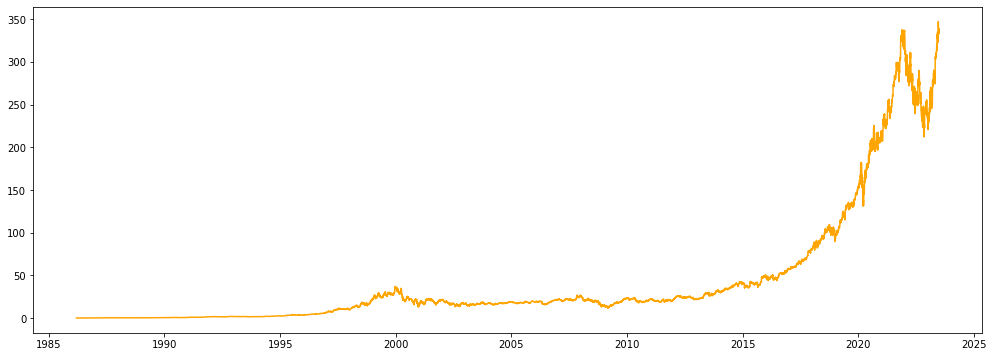

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 6))
plt.plot(df.index, df['Close'], color='orange');

## Windowed dataframe <a class="anchor" id="WindowedDataFrame"></a>
[TOC](#TOC)

__Introduction__
* A __windowed dataframe__ typically refers to a DataFrame that has been processed using a __window__ or __rolling operation__ in the context of time-series data. 
* __Window functions__, also known as rolling or sliding functions, are used to perform calculations over a specific window or __subset of data points__ within a time-ordered dataset. 
* These window operations are often used for tasks like smoothing data etc.
* In __Pandas__, you can create a windowed DataFrame by using functions such as `.rolling()`, `.expanding()`, or `.ewm()` (i.e. "Exponentially Weighted Moving Average") to define the window and then applying operations like mean or sum.

In [78]:
import numpy as np

def WindowedDataframe(dfrSource, strFirstDate, strLastDate, intExtraTargetColumns=3):
  '''
  Converts a dataframe into a windowed dataframe:
  - columns "Date" and "Target": 
       original x and y values
  - columns in between: 
       "Target-1", "Target-2" etc.: values at t - delay
       
  Check result: 
  - take diagonals in slasch direction, i.e. /
  - must be identical values
  
  Inspiration:
  - https://github.com/itzsamr/Microsoft-Stock-LSTM-Prediction/blob/main/Stock%20Price%20Prediction/Microsoft%20Stock%20Price%20Prediction%20with%20LSTM%20Neural%20Networks.ipynb
  - maybe not the most elegant solution
  
  When       Who What
  2023 10 02 dh  Created
  '''

  # init dates
  datFirst = str_to_datetime(strFirstDate)
  datLast  = str_to_datetime(strLastDate)
  datTarget = datFirst
  ldatDates = []
    
  # more initializations
  la1fltX, lfltY = [], []
  blnLastTime = False
  intAllTargetColumns = intExtraTargetColumns+1

  while True:
    dfrTailSubset = dfrSource.loc[:datTarget].tail(intAllTargetColumns)
    
    if len(dfrTailSubset) != intAllTargetColumns:
      p(f'Error: Window of size {intExtraTargetColumns} is too large for date {datTarget}.')
      return

    a1fltTailSubsetPrices = dfrTailSubset['Close'].to_numpy()
    a1fltX = a1fltTailSubsetPrices[:-1] 
    flty = a1fltTailSubsetPrices[-1]

    ldatDates.append(datTarget)
    la1fltX.append(a1fltX)
    lfltY.append(flty)

    dfrNextWeek = dfrSource.loc[datTarget:datTarget+datetime.timedelta(days=7)]
    strNextDatetime = str(dfrNextWeek.head(2).tail(1).index.values[0])
    strNextDate = strNextDatetime.split('T')[0]
    lstrDateElements = strNextDate.split('-')
    strYear, strMonth, strDay = lstrDateElements
    datNextDate = datetime.datetime(day=int(strDay), month=int(strMonth), year=int(strYear))
    
    if blnLastTime:
      break # exit loop
    
    # prepare next loop
    datTarget = datNextDate
    if datTarget == datLast:
      blnLastTime = True
    
  # compose final dataframe
  dfrResult = pd.DataFrame({})
  dfrResult['Target Date'] = ldatDates
  a2fltX = np.array(la1fltX)

  # add delay columns
  for intCurrTargetCol in range(intExtraTargetColumns):
    a2fltX[:, intCurrTargetCol]
    dfrResult[f'Target-{intExtraTargetColumns-intCurrTargetCol}'] = a2fltX[:, intCurrTargetCol]
  
  # add original target
  dfrResult['Target'] = lfltY

  return dfrResult

# define training period
# - i.e. most very old data is ignored
strTrainFirstDate = '2021-03-25'
strTrainLastDate = '2022-03-23'

# create windowed dataframe
intExtraTargetColumns = 3 
p(f"Windowed dataframe".upper())
p(f"- Diagonals in / direction have identical values")
p(f"- Delays: {intExtraTargetColumns}")
p(f"- one year")
p(f"- without holidays, thus < 365 records")
p(f"- next step: will be split into train, valid and test dataset")
p()

windowed_df = WindowedDataframe(df, strTrainFirstDate, strTrainLastDate, intExtraTargetColumns)
u.ShortDataFrameDisplay(windowed_df,(intExtraTargetColumns+1)*2)

WINDOWED DATAFRAME
- Diagonals in / direction have identical values
- Delays: 3
- 1 year
- 1 without holidays, thus < 365 records

DataFrame 'windowed_df':


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,230.814819,232.369995,230.296478,227.244858
1,2021-03-26,232.369995,230.296478,227.244858,231.294113
2,2021-03-29,230.296478,227.244858,231.294113,230.081299
3,2021-03-30,227.244858,231.294113,230.081299,226.765640
...,...,...,...,...,...
248,2022-03-18,283.140594,290.279480,291.097961,296.235168
249,2022-03-21,290.279480,291.097961,296.235168,294.982910
250,2022-03-22,291.097961,296.235168,294.982910,299.814453
251,2022-03-23,296.235168,294.982910,299.814453,295.308258


In [87]:
def windowed_df_to_date_X_y(windowed_dataframe):
  '''
  Converts dataframe into three numpy array: dates, X, y.
  When       Who     What
  2023 06 26 itzsamr Created
  '''
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)
p("Variables test period:".upper())
p("- all numpy arrays")
p("- shapes:")
p("  - dates:", dates.shape)
p("  - X:    ", X.shape)
p("  - y:    ", y.shape)

VARIABLES TRAINING PERIOD:
- all numpy arrays
- shapes:
  - dates: (252,)
  - X:     (252, 3, 1)
  - y:     (252,)


## Splitting data into train, validation and test sets <a class="anchor" id="SplittingDataIntoDatasets"></a>
[TOC](#TOC)

X SHAPES:
- train: (201, 3, 1)
- valid: (25, 3, 1)
- test:  (26, 3, 1)



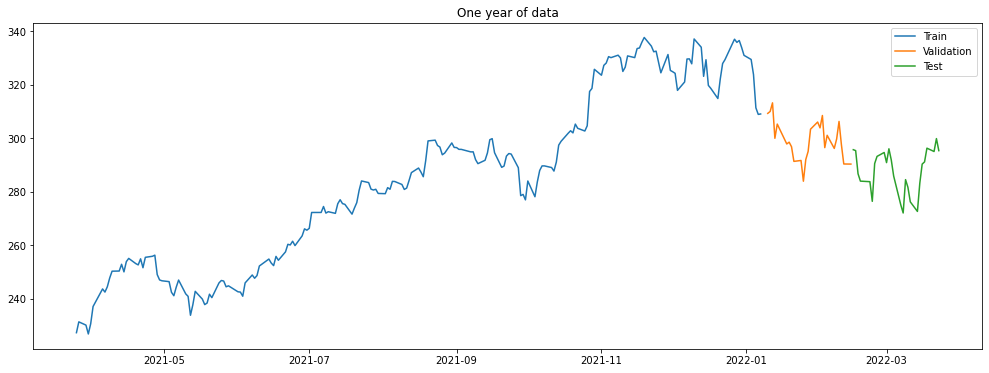

In [98]:
# define record count for train, valid, test
cfltProportionTrain = 0.8
cfltProportionValid = 0.1

intRecords = len(dates)
intRecordsTrain = int(intRecords * cfltProportionTrain)
intRecordsTrainValid = int(intRecords * (fltProportionTrain + cfltProportionValid))

dates_train, X_train, y_train = dates[                    :intRecordsTrain],      X[                    :intRecordsTrain],      y[                    :intRecordsTrain     ]
dates_val,   X_val,   y_val   = dates[intRecordsTrain     :intRecordsTrainValid], X[intRecordsTrain     :intRecordsTrainValid], y[intRecordsTrain     :intRecordsTrainValid]
dates_test,  X_test,  y_test  = dates[intRecordsTrainValid:],                     X[intRecordsTrainValid:],                     y[intRecordsTrainValid:                    ]

p("X shapes:".upper())
p("- train:",X_train.shape)
p("- valid:",X_val.shape)
p("- test: ",X_test.shape)
p()

plt.figure(figsize=(17, 6))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.title("One year of data")

plt.legend(['Train', 'Validation', 'Test']);

## Training an LSTM Model <a class="anchor" id="TrainingLstmModel"></a>
[TOC](#TOC)

__Introduction__
* The following code is for creating and training a __Long Short-Term Memory (LSTM) neural network model__:
    * It uses __TensorFlow/Keras__.
    * LSTM is a type of __recurrent neural network (RNN)__ often used for 
        * sequential data like __time series__. 
        * natural language processing tasks (__NLP__).
* Step-by-step explanation:
    * Libraries:
        * __Sequential__ is a Keras model type that allows you to __build a neural network layer by layer__ in a sequential manner.
        * __Adam__ is an __optimization algorithm__ used to update the weights of the neural network during training.
        * The __layers__ module is used to define different layers of the neural network.
    * Creating the neural network model:
        * `model = Sequential(...)` __initializes__ a sequential neural network model.
        * `layers.Input((3, 1))` defines the __input layer__ with a shape of (3, 1), indicating that the model expects input sequences of length 3 with one feature at each time step.
        * `layers.LSTM(64)` adds an __LSTM layer__ with 64 units to the model. This layer will process the input sequences and learn patterns in the data over time.
        * `layers.Dense(32, activation='relu')` adds a __dense layer__ (i.e. fully connected layer) with 32 units and a __ReLU activation__ function. This layer __introduces non-linearity__ into the model.
        * `layers.Dense(1)` adds a __final dense layer__ with a single unit, which is used for regression tasks where the __model predicts a single continuous value__ as the output.
    * Compiling the model:
        * `model.compile(...)` configures the training process of the model.
        * `loss='mse'` specifies the mean squared error as the __loss function__, which is often used for regression tasks. The model will try to minimize this loss during training.
        * `optimizer=Adam(learning_rate=0.001)` sets the __Adam optimizer__ with a learning rate of 0.001, which is used to update the model's weights during training.
        * `metrics=['mean_absolute_error']` defines the metric(s) used to evaluate the model's performance during training. In this case, it calculates the mean absolute error (MAE) as an additional metric.
    * Training the model:
        * `model.fit(...)` trains the model using the provided training data (X_train, y_train) and validates it on the validation data (X_val, y_val). 
        * The training process runs for __100 epochs__, meaning the model will go through the entire training dataset 100 times, adjusting its weights to minimize the loss.
* During training, the model aims to learn patterns in the input data and minimize the mean squared error between its predictions and the actual target values (y_train). After training, you can use the trained model to make predictions on new data.

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 78ms/step - loss: 81764.2344 - mean_absolute_error: 284.1825 - val_loss: 89628.7500 - val_mean_absolute_error: 299.2950
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 81550.6172 - mean_absolute_error: 283.8073 - val_loss: 89450.0000 - val_mean_absolute_error: 298.9962
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 81386.6094 - mean_absolute_error: 283.5179 - val_loss: 89273.7812 - val_mean_absolute_error: 298.7014
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 81204.6406 - mean_absolute_error: 283.1959 - val_loss: 89048.6797 - val_mean_absolute_error: 298.3243
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 80966.9844 - mean_absolute_error: 282.7753 - val_loss: 88758.3672 - val_mean_absolute_error: 297.8374
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 80672.8125 - mean_absolute_error: 282.2526 - val_loss: 88409.61

## Dataset plots: predictions vs. observations<a class="anchor" id="DatasetPlots"></a>
[TOC](#TOC)

### Training<a class="anchor" id="PlotWithinTraining"></a>
[TOC](#TOC)

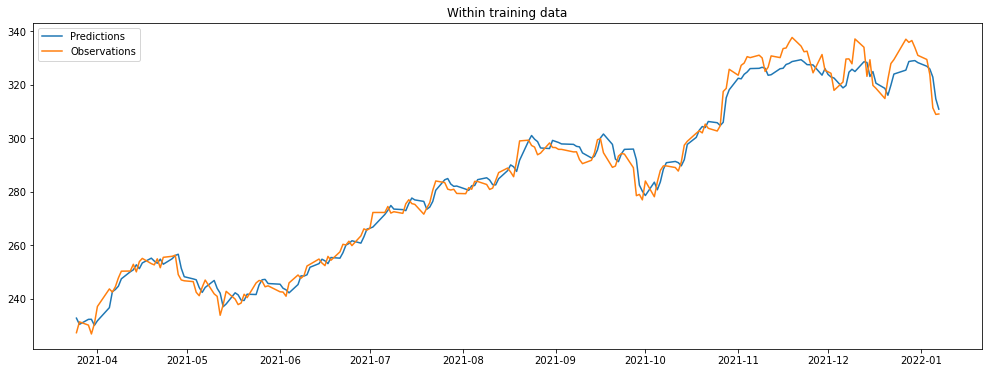

In [105]:
train_predictions = model.predict(X_train).flatten()
plt.figure(figsize=(17, 6))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Predictions', 'Observations'])
plt.title("Within training data")
plt.show()

### Validation<a class="anchor" id="PlotWithinValidation"></a>
[TOC](#TOC)

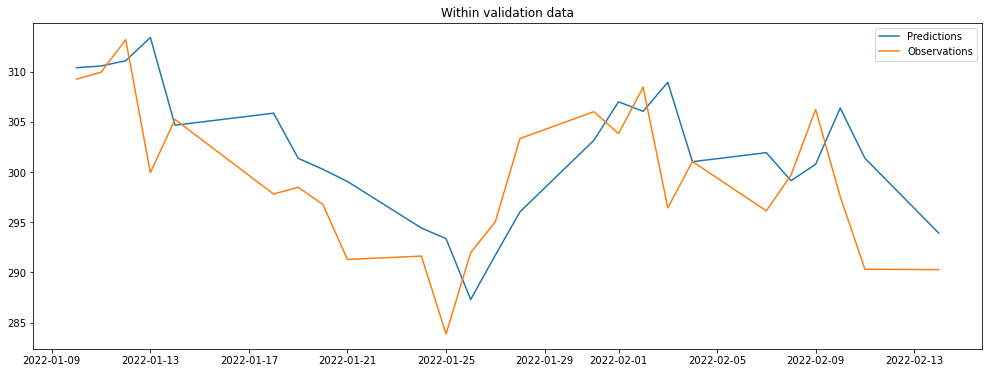

In [106]:
val_predictions = model.predict(X_val).flatten()
plt.figure(figsize=(17, 6))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.title("Within validation data")
plt.legend(['Predictions', 'Observations'])
plt.show()

### Testing <a class="anchor" id="PlotWithinTesting"></a>
[TOC](#TOC)

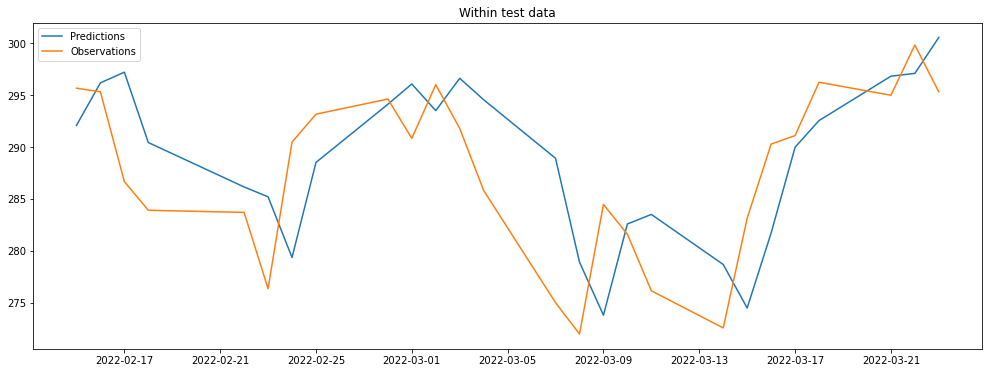

In [107]:
test_predictions = model.predict(X_test).flatten()
plt.figure(figsize=(17, 6))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.title("Within test data")
plt.legend(['Predictions', 'Observations'])
plt.show()

### All datasets <a class="anchor" id="PlotWithinAll"></a>
[TOC](#TOC)

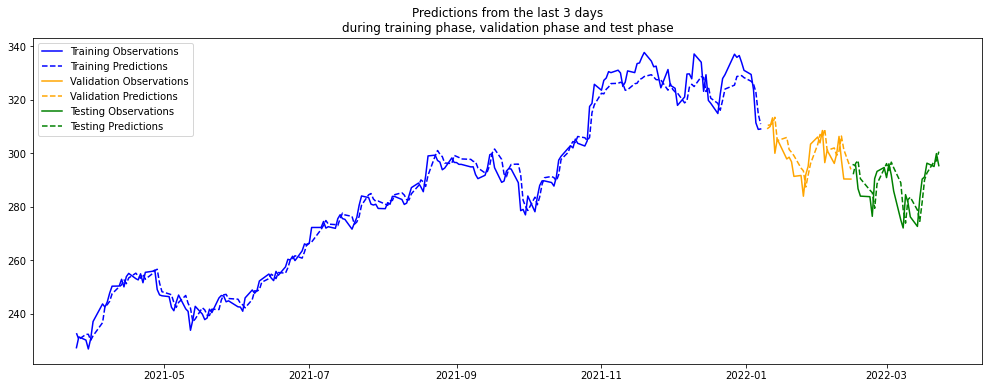

In [120]:
plt.figure(figsize=(17, 6))

plt.plot(dates_train, y_train,color="blue",linestyle='-')
plt.plot(dates_train, train_predictions,color="blue",linestyle='--')

plt.plot(dates_val, y_val,color="orange",linestyle='-')
plt.plot(dates_val, val_predictions,color="orange",linestyle='--')

plt.plot(dates_test, y_test,color="green",linestyle='-')
plt.plot(dates_test, test_predictions,color="green",linestyle='--')

plt.legend([
    'Training Observations',  'Training Predictions', 
    'Validation Observations','Validation Predictions', 
    'Testing Observations',   'Testing Predictions'
])
plt.title(f"Predictions from the last {intExtraTargetColumns} days\nduring training phase, validation phase and test phase")
plt.show()

__Observation__
* The predicted stock market prices follow the true prices __tightly__.
* The predicted values are always __slightly behind__ the true values.
* Different from the Prophet model, the model here delivers __only short-term predictions__: the next day from the last 3 prices (including today's price).

## Recursive Predictions for Validation and Testing Data <a class="anchor" id="RecursivePredictionsForValidationAndTestingData"></a>
[TOC](#TOC)

__Introduction__
* The term "recursive predictions" refers to a method of making sequential predictions using a trained LSTM model:
    * Instead of making predictions for all data points in the validation and testing datasets at once, it makes __predictions one step at a time__.
    * Each __prediction__ is __used as input__ for predicting the next data point. 
    * This process is often used when dealing with time series data, where the prediction for one time step depends on the previous time steps.
* Explanations on the following code:
    * `recursive_dates` is a concatenated array of dates from both the validation and testing datasets.
    * This array represents the timeline of dates for which predictions are to be made.
    * The code iterates over each `target_date` in the `recursive_dates` array.
    * Inside the loop, it creates a `last_window` by deep copying the last window of the training data (`X_train[-1]`). This `last_window` represents the most recent sequence of input data points.
    * It then uses the trained LSTM model (`model`) to make a prediction for the next data point in the sequence. 
    * This is done by passing the `last_window` as input to the model using `model.predict`.
    * The result is flattened to get a single value as the prediction.
    * The predicted value (`next_prediction`) is appended to the `recursive_predictions` list.
    * Finally, the last element of the `last_window` is updated with the `next_prediction`. 
    * This means that the most recent prediction is included in the input data for the next iteration of the loop.
    * This process continues until predictions have been made for all the dates in the `recursive_dates` array. 
* Essentially, the model makes a prediction for the next time step, and then that prediction is used as part of the input for predicting the next time step, creating a sequence of predictions that can be compared to the actual data to evaluate the model's performance.

In [132]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test]) # a1datRecursiveDates

for datTargetDate in recursive_dates:
  a2fltLastWindow = deepcopy(X_train[-1])
  a1fltNextPrediction = model.predict(np.array([a2fltLastWindow])).flatten()
  recursive_predictions.append(a1fltNextPrediction)
  a2fltLastWindow[-1] = a1fltNextPrediction

## Add recursive data to plot <a class="anchor" id="AddRecursiveDataToPlot"></a>
[TOC](#TOC)

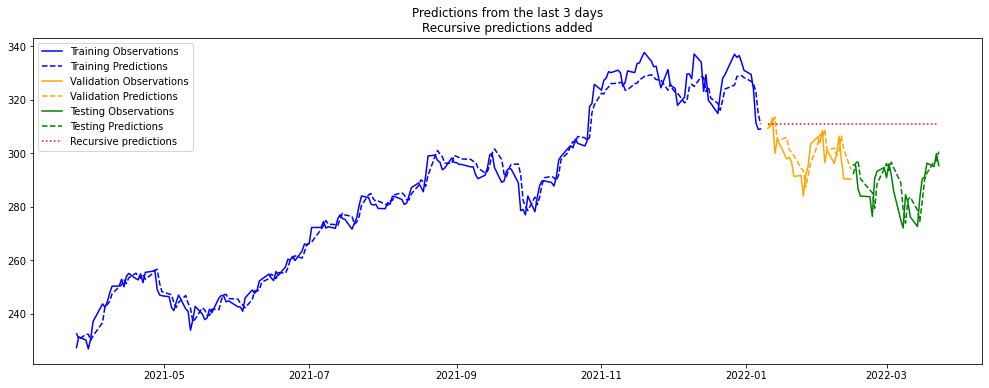

In [133]:
plt.figure(figsize=(17, 6))

plt.plot(dates_train, y_train,color="blue",linestyle='-')
plt.plot(dates_train, train_predictions,color="blue",linestyle='--')

plt.plot(dates_val, y_val,color="orange",linestyle='-')
plt.plot(dates_val, val_predictions,color="orange",linestyle='--')

plt.plot(dates_test, y_test,color="green",linestyle='-')
plt.plot(dates_test, test_predictions,color="green",linestyle='--')

plt.plot(recursive_dates, recursive_predictions,color="red",linestyle=':')

plt.legend([
    'Training Observations',  'Training Predictions', 
    'Validation Observations','Validation Predictions', 
    'Testing Observations',   'Testing Predictions',
    "Recursive predictions"
])
plt.title(f"Predictions from the last {intExtraTargetColumns} days\nRecursive predictions added")
plt.show()

## Questions <a class="anchor" id="Questions"></a>
[TOC](#TOC)

* When compiling the LSTM model: Why does the tutorial propose `loss='mse'` and at the same time `metrics=['mean_absolute_error']`? Why not the __same metric__?
* What is the interpretation of the __straight, horizontal line__ for the __recursive predictions__?